In [1]:

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

import sys
sys.path.insert(0, "Code/")

from Search import *


In [2]:
# Define the base components for the search

# h is the perturbation
def perturber_continuous(model, X, h):
    X_pert = X + h
    y_pert = model.predict_proba(X_pert)[:, 1]
    return X_pert, y_pert

#h[0] is the index, h[1] is the new value
def perturber_binary(model, X, h):
    X_pert = X
    X_pert[:, h[0]] = h[1]
    y_pert = model.predict_proba(X_pert)[:, 1]
    return X_pert, y_pert

#h[0] is the set of indices, h[1] is the new 1-hot set of values
def perturber_categorical(model, X, h):
    X_pert = X
    X_pert[:, h[0]] = h[1]
    y_pert = model.predict_proba(X_pert)[:, 1]
    return X_pert, y_pert

def checker_prob(y, y_pert, min_change = 0.25):
    return 1.0 * (np.abs(y_pert - y) >= min_change)

def checker_label(y, y_pert):
    return 1.0 * (np.rint(y_pert) != np.rint(y))

def learner(X, success):
    region = DecisionTreeClassifier(min_samples_leaf = 20, min_impurity_decrease = 0.025)
    region.fit(X, success)
    return region


In [3]:
# Load the data

df = pd.read_csv("Data/adult.csv")

print(df.head())

# Process the categorical variables

df = pd.get_dummies(df, columns=["workclass", "education", "marital-status", "occupation", "relationship", "race", "gender", "native-country"])

df["income"] = df["income"].map({ "<=50K": 0, ">50K": 1 })

names = list(df)
print(names)

# Setup for training and testing models

y = df["income"].values
df.drop("income", axis = 1, inplace = True)

x = df.values

d = x.shape[1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33)



   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country incom

In [4]:

def run(checker):

    print("")
    print("Fitting Original Model")

    model = RandomForestClassifier().fit(x_train, y_train)

    print("Train Acc:", model.score(x_train, y_train))
    acc_original = model.score(x_test, y_test)
    print("Test Acc:", acc_original)
    
    print("Checking for instabilities in 'Age'")

    # Configure the perturbation
    index = names.index("age")

    heuristics = []
    pert = np.zeros((1, d))
    pert[0, index] = 1.0
    heuristics.append(pert)

    y_hat_train = model.predict_proba(x_train)[:, 1]
    y_hat_test = model.predict_proba(x_test)[:, 1]

    out_original = search(model, x_train, y_hat_train, heuristics, perturber_continuous, checker, learner, use_val = True, X_val = x_test, y_val = y_hat_test, min_explainability = 0.9, use_acc = True, verbose = True)

    print("Where does this explanation apply?")
    for o in out_original:
        plt.figure()
        plot_tree(o.region, filled = True)
        plt.show()
        plt.close()
        
    print("")
    print("Fix Number 1:  Apply the perturbation indiscriminately with Data Augmentation")

    x_train_pert, _ = perturber_continuous(model, x_train, heuristics[0])

    print("Additional Training Points: ", x_train_pert.shape[0])

    x_train_pert = np.vstack((x_train, x_train_pert))

    y_train_pert = np.hstack((y_train, y_train))

    print("Fitting Model")

    model_new = RandomForestClassifier().fit(x_train_pert, y_train_pert)

    y_hat_train = model_new.predict_proba(x_train)[:, 1]
    y_hat_test = model_new.predict_proba(x_test)[:, 1]

    print("Train Acc:", model_new.score(x_train, y_train))
    acc_f1 = model_new.score(x_test, y_test)
    print("Test Acc:", acc_f1)

    out_f1 = search(model_new, x_train, y_hat_train, heuristics, perturber_continuous, checker, learner, use_val = True, X_val = x_test, y_val = y_hat_test, min_explainability = 0.9, use_acc = True, verbose = True)

    print("")
    print("Fix Number 2:  Apply the perturbation only where necessary with Data Augmentation")

    x_train_pert, _ = perturber_continuous(model, x_train, heuristics[0])

    worked = out_original[0].indices

    print("Additional Training Points: ", np.sum(worked))

    indices = np.where(worked == 1)[0]

    x_train_pert = np.vstack((x_train, x_train[indices, :]))
    y_train_pert = np.hstack((y_train, y_train[indices]))

    print("Fitting Model")

    model_new = RandomForestClassifier().fit(x_train_pert, y_train_pert)

    y_hat_train = model_new.predict_proba(x_train)[:, 1]
    y_hat_test = model_new.predict_proba(x_test)[:, 1]

    print("Train Acc:", model_new.score(x_train, y_train))
    acc_f2 = model_new.score(x_test, y_test)
    print("Test Acc:", acc_f2)

    out_f2 = search(model_new, x_train, y_hat_train, heuristics, perturber_continuous, checker, learner, use_val = True, X_val = x_test, y_val = y_hat_test, min_explainability = 0.9, use_acc = True, verbose = True)

    print("")
    print("Orignal: ", out_original[0].counts)
    print("F1: ", out_f1[0].counts)
    print("F2: ", out_f2[0].counts)
    print("")
    
    return acc_original, acc_f1, acc_f1, out_original[0].counts, out_f1[0].counts, out_f2[0].counts



###
Trial 0
###

Fitting Original Model
Train Acc: 0.9998472069429165
Test Acc: 0.852463084749969
Checking for instabilities in 'Age'

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Success on Train:  466.0
Train Metrics:  0.9857596870798191
Success on Val:  422.0
Validation Metrics:  0.9738180915746371
Accepted

Where does this explanation apply?


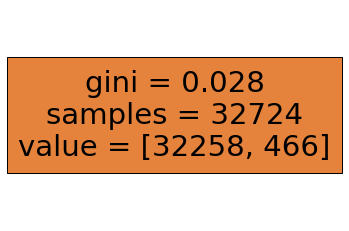


Fix Number 1:  Apply the perturbation indiscriminately with Data Augmentation
Additional Training Points:  32724
Fitting Model
Train Acc: 0.9999083241657499
Test Acc: 0.8493609628986226

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Success on Train:  3.0
Train Metrics:  0.9999083241657499
Success on Val:  339.0
Validation Metrics:  0.9789676138478719
Accepted


Fix Number 2:  Apply the perturbation only where necessary with Data Augmentation
Additional Training Points:  466.0
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.852401042312942

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

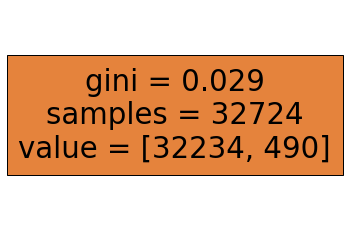


Fix Number 1:  Apply the perturbation indiscriminately with Data Augmentation
Additional Training Points:  32724
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.8492368780245688

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Success on Train:  3.0
Train Metrics:  0.9999083241657499
Success on Val:  349.0
Validation Metrics:  0.9783471894776027
Accepted


Fix Number 2:  Apply the perturbation only where necessary with Data Augmentation
Additional Training Points:  490.0
Fitting Model
Train Acc: 0.9999083241657499
Test Acc: 0.8509120238242959

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

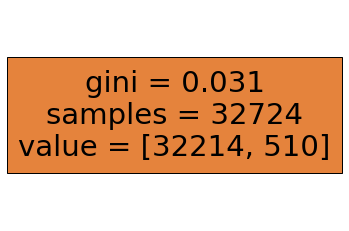


Fix Number 1:  Apply the perturbation indiscriminately with Data Augmentation
Additional Training Points:  32724
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.8503536418910534

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Success on Train:  7.0
Train Metrics:  0.9997860897200831
Success on Val:  353.0
Validation Metrics:  0.978099019729495
Accepted


Fix Number 2:  Apply the perturbation only where necessary with Data Augmentation
Additional Training Points:  510.0
Fitting Model
Train Acc: 0.9998472069429165
Test Acc: 0.8530835091202382

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

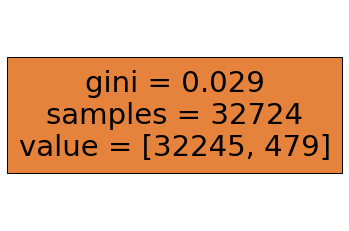


Fix Number 1:  Apply the perturbation indiscriminately with Data Augmentation
Additional Training Points:  32724
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.8486164536542995

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Success on Train:  5.0
Train Metrics:  0.9998472069429165
Success on Val:  357.0
Validation Metrics:  0.9778508499813873
Accepted


Fix Number 2:  Apply the perturbation only where necessary with Data Augmentation
Additional Training Points:  479.0
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.8514083633205112

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

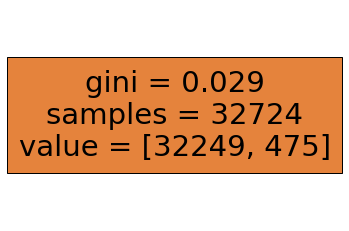


Fix Number 1:  Apply the perturbation indiscriminately with Data Augmentation
Additional Training Points:  32724
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.8488646234024072

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Success on Train:  5.0
Train Metrics:  0.9998472069429165
Success on Val:  340.0
Validation Metrics:  0.978905571410845
Accepted


Fix Number 2:  Apply the perturbation only where necessary with Data Augmentation
Additional Training Points:  475.0
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.8515324481945651

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

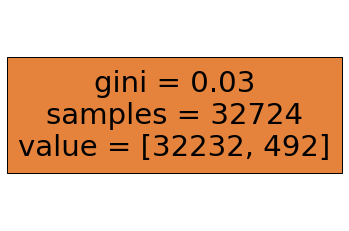


Fix Number 1:  Apply the perturbation indiscriminately with Data Augmentation
Additional Training Points:  32724
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.8497332175207842

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Success on Train:  1.0
Train Metrics:  0.9999694413885833
Success on Val:  358.0
Validation Metrics:  0.9777888075443604
Accepted


Fix Number 2:  Apply the perturbation only where necessary with Data Augmentation
Additional Training Points:  492.0
Fitting Model
Train Acc: 0.9999083241657499
Test Acc: 0.8529594242461844

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

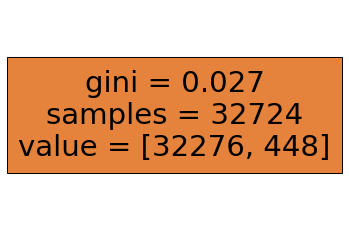


Fix Number 1:  Apply the perturbation indiscriminately with Data Augmentation
Additional Training Points:  32724
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.8494850477726765

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Success on Train:  3.0
Train Metrics:  0.9999083241657499
Success on Val:  343.0
Validation Metrics:  0.9787194440997642
Accepted


Fix Number 2:  Apply the perturbation only where necessary with Data Augmentation
Additional Training Points:  448.0
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.853269636431319

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

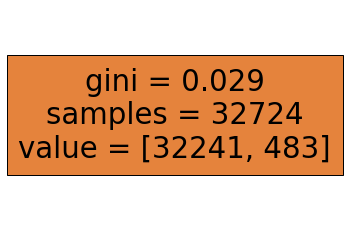


Fix Number 1:  Apply the perturbation indiscriminately with Data Augmentation
Additional Training Points:  32724
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.8475617322248418

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Success on Train:  3.0
Train Metrics:  0.9999083241657499
Success on Val:  335.0
Validation Metrics:  0.9792157835959796
Accepted


Fix Number 2:  Apply the perturbation only where necessary with Data Augmentation
Additional Training Points:  483.0
Fitting Model
Train Acc: 0.9998472069429165
Test Acc: 0.8529594242461844

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

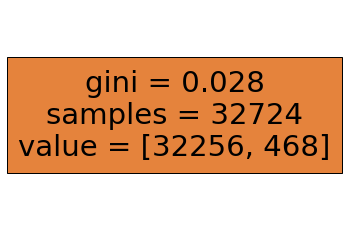


Fix Number 1:  Apply the perturbation indiscriminately with Data Augmentation
Additional Training Points:  32724
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.8500434297059188

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Success on Train:  3.0
Train Metrics:  0.9999083241657499
Success on Val:  348.0
Validation Metrics:  0.9784092319146296
Accepted


Fix Number 2:  Apply the perturbation only where necessary with Data Augmentation
Additional Training Points:  468.0
Fitting Model
Train Acc: 0.9999083241657499
Test Acc: 0.8516565330686189

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

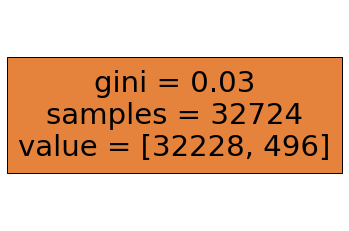


Fix Number 1:  Apply the perturbation indiscriminately with Data Augmentation
Additional Training Points:  32724
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.8497952599578111

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Success on Train:  3.0
Train Metrics:  0.9999083241657499
Success on Val:  337.0
Validation Metrics:  0.9790916987219258
Accepted


Fix Number 2:  Apply the perturbation only where necessary with Data Augmentation
Additional Training Points:  496.0
Fitting Model
Train Acc: 0.9999083241657499
Test Acc: 0.8525251271869959

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [5]:
a_o = []
a_1 = []
a_2 = []
r_o = []
r_1 = []
r_2 = []
for i in range(10):
    print("###")
    print("Trial", i)
    print("###")
    res = run(checker_label)
    a_o.append(res[0])
    a_1.append(res[1])
    a_2.append(res[2])
    r_o.append(res[3])
    r_1.append(res[4])
    r_2.append(res[5])
    

In [6]:
print(np.mean(a_o), np.mean(a_1), np.mean(a_2))
print(np.mean(r_o, axis = 0), np.mean(r_1, axis = 0), np.mean(r_2, axis = 0))

0.8539272862638045 0.8493051247052985 0.8493051247052985
[480.7 398.6] [  3.6 345.9] [341.6 432.5]


###
Trial 0
###

Fitting Original Model
Train Acc: 0.9999083241657499
Test Acc: 0.8535178061794267
Checking for instabilities in 'Age'

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Success on Train:  488.0
Train Metrics:  0.9850873976286517
Success on Val:  150.0
Validation Metrics:  0.990693634445961
Accepted

Where does this explanation apply?


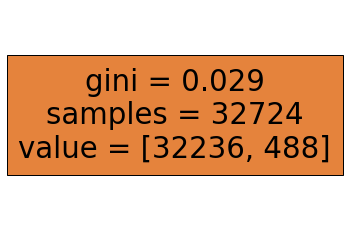


Fix Number 1:  Apply the perturbation indiscriminately with Data Augmentation
Additional Training Points:  32724
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.8488025809653803

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Success on Train:  9.0
Train Metrics:  0.9997249724972497
Success on Val:  117.0
Validation Metrics:  0.9927410348678496
Accepted


Fix Number 2:  Apply the perturbation only where necessary with Data Augmentation
Additional Training Points:  488.0
Fitting Model
Train Acc: 0.9999083241657499
Test Acc: 0.853269636431319

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

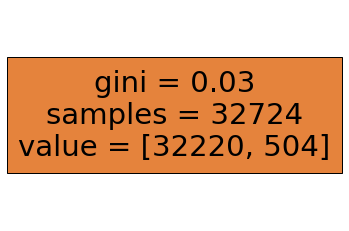


Fix Number 1:  Apply the perturbation indiscriminately with Data Augmentation
Additional Training Points:  32724
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.8493609628986226

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Success on Train:  7.0
Train Metrics:  0.9997860897200831
Success on Val:  122.0
Validation Metrics:  0.992430822682715
Accepted


Fix Number 2:  Apply the perturbation only where necessary with Data Augmentation
Additional Training Points:  504.0
Fitting Model
Train Acc: 0.9999083241657499
Test Acc: 0.8536418910534805

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

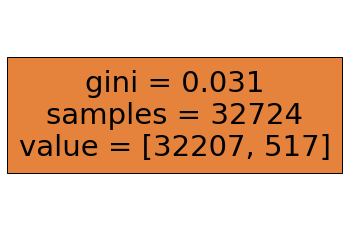


Fix Number 1:  Apply the perturbation indiscriminately with Data Augmentation
Additional Training Points:  32724
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.8484303263432188

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Success on Train:  10.0
Train Metrics:  0.999694413885833
Success on Val:  135.0
Validation Metrics:  0.991624271001365
Accepted


Fix Number 2:  Apply the perturbation only where necessary with Data Augmentation
Additional Training Points:  517.0
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.8528353393721305

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

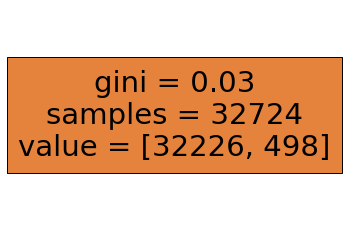


Fix Number 1:  Apply the perturbation indiscriminately with Data Augmentation
Additional Training Points:  32724
Fitting Model
Train Acc: 0.9999083241657499
Test Acc: 0.8489266658394342

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Success on Train:  8.0
Train Metrics:  0.9997555311086664
Success on Val:  131.0
Validation Metrics:  0.9918724407494727
Accepted


Fix Number 2:  Apply the perturbation only where necessary with Data Augmentation
Additional Training Points:  498.0
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.8523389998759151

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

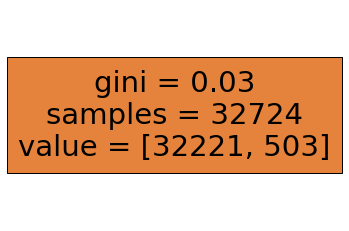


Fix Number 1:  Apply the perturbation indiscriminately with Data Augmentation
Additional Training Points:  32724
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.8479339868470034

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Success on Train:  8.0
Train Metrics:  0.9997555311086664
Success on Val:  129.0
Validation Metrics:  0.9919965256235265
Accepted


Fix Number 2:  Apply the perturbation only where necessary with Data Augmentation
Additional Training Points:  503.0
Fitting Model
Train Acc: 0.9998472069429165
Test Acc: 0.8546345700459114

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

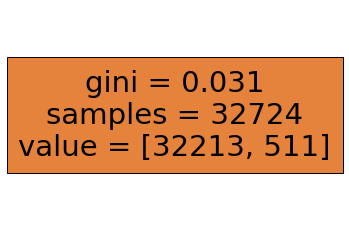


Fix Number 1:  Apply the perturbation indiscriminately with Data Augmentation
Additional Training Points:  32724
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.8499813872688919

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Success on Train:  4.0
Train Metrics:  0.9998777655543332
Success on Val:  124.0
Validation Metrics:  0.9923067378086611
Accepted


Fix Number 2:  Apply the perturbation only where necessary with Data Augmentation
Additional Training Points:  511.0
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.8528353393721305

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

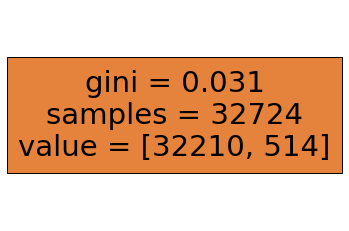


Fix Number 1:  Apply the perturbation indiscriminately with Data Augmentation
Additional Training Points:  32724
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.8488025809653803

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Success on Train:  8.0
Train Metrics:  0.9997555311086664
Success on Val:  125.0
Validation Metrics:  0.9922446953716342
Accepted


Fix Number 2:  Apply the perturbation only where necessary with Data Augmentation
Additional Training Points:  514.0
Fitting Model
Train Acc: 0.9998472069429165
Test Acc: 0.8527732969351036

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

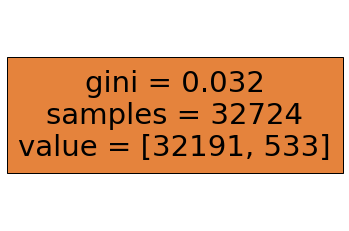


Fix Number 1:  Apply the perturbation indiscriminately with Data Augmentation
Additional Training Points:  32724
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.8496091326467303

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Success on Train:  6.0
Train Metrics:  0.9998166483314999
Success on Val:  136.0
Validation Metrics:  0.991562228564338
Accepted


Fix Number 2:  Apply the perturbation only where necessary with Data Augmentation
Additional Training Points:  533.0
Fitting Model
Train Acc: 0.9999083241657499
Test Acc: 0.8532075939942921

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

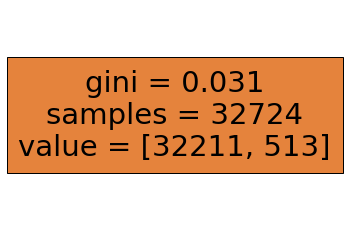


Fix Number 1:  Apply the perturbation indiscriminately with Data Augmentation
Additional Training Points:  32724
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.8486164536542995

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Success on Train:  12.0
Train Metrics:  0.9996332966629996
Success on Val:  123.0
Validation Metrics:  0.9923687802456881
Accepted


Fix Number 2:  Apply the perturbation only where necessary with Data Augmentation
Additional Training Points:  513.0
Fitting Model
Train Acc: 0.9998472069429165
Test Acc: 0.8539521032386153

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

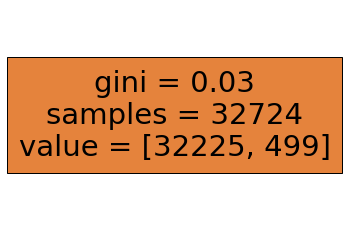


Fix Number 1:  Apply the perturbation indiscriminately with Data Augmentation
Additional Training Points:  32724
Fitting Model
Train Acc: 0.9998777655543332
Test Acc: 0.8491127931505149

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Success on Train:  7.0
Train Metrics:  0.9997860897200831
Success on Val:  123.0
Validation Metrics:  0.9923687802456881
Accepted


Fix Number 2:  Apply the perturbation only where necessary with Data Augmentation
Additional Training Points:  499.0
Fitting Model
Train Acc: 0.9999083241657499
Test Acc: 0.854076188112669

Heuristic:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [9]:
a_o = []
a_1 = []
a_2 = []
r_o = []
r_1 = []
r_2 = []
for i in range(10):
    print("###")
    print("Trial", i)
    print("###")
    
    res = run(checker_prob)
    a_o.append(res[0])
    a_1.append(res[1])
    a_2.append(res[2])
    r_o.append(res[3])
    r_1.append(res[4])
    r_2.append(res[5])
    

In [10]:
print(np.mean(a_o), np.mean(a_1), np.mean(a_2))
print(np.mean(r_o, axis = 0), np.mean(r_1, axis = 0), np.mean(r_2, axis = 0))

0.8540885966000745 0.8489576870579476 0.8489576870579476
[508.  157.5] [  7.9 126.5] [604.9 195.8]
